In [1]:
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np

import common

In [3]:
data_set_path = "../temp_sets_100/"

## Time data discretisation

In [4]:
def date_discretisation(date):
    if not pd.isna(date):
        # Do not use "-" as connector, because Pandas might read it as date or time!!
        return str(date.quarter) + "&" + str(date.dayofweek)
    else:
        return "Na"

In [5]:
def datetime_discretisation(date):
    if not pd.isna(date):
        # Do not use "-" as connector, because Pandas might read it as date or time!!
        return str(date.quarter) + "&" + str(date.dayofweek) + "&" + str(date.hour)
    else:
        return "Na"

## Read Data

In [6]:
admissions_df = common.read_csv_no_rowid(data_set_path+"admissions.csv")

In [7]:
admissions_df.drop(['diagnosis', 'hospital_expire_flag'], axis=1, inplace=True)

In [8]:
admissions_df['admittime'] = pd.to_datetime(admissions_df['admittime'])
admissions_df['dischtime'] = pd.to_datetime(admissions_df['dischtime'])
admissions_df['deathtime'] = pd.to_datetime(admissions_df['deathtime'])
admissions_df['edregtime'] = pd.to_datetime(admissions_df['edregtime'])
admissions_df['edouttime'] = pd.to_datetime(admissions_df['edouttime'])

---

##  Build Network

In [9]:
len(admissions_df)

143

In [10]:
from pgmpy.estimators import HillClimbSearch

hc = HillClimbSearch(admissions_df)
best_model = hc.estimate()
print(best_model.edges())
edges = best_model.edges()

  0%|          | 0/1000000 [00:00<?, ?it/s]

[('subject_id', 'edregtime'), ('hadm_id', 'subject_id'), ('admittime', 'dischtime'), ('dischtime', 'hadm_id'), ('deathtime', 'marital_status'), ('deathtime', 'religion'), ('deathtime', 'edouttime'), ('ethnicity', 'admittime'), ('edregtime', 'deathtime')]


In [11]:
features = list(best_model.nodes())

In [12]:
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import BayesianEstimator

bn_admissions_model = BayesianNetwork(edges)

In [13]:
len(edges)

9

In [14]:
bn_admissions_model.fit(
    admissions_df.loc[:, features], 
    estimator=BayesianEstimator, 
    prior_type="BDeu", 
    n_jobs=8) # default equivalent_sample_size=5

## Generation test

In [15]:
bn_admissions_model.get_cpds()[0].values.shape

(100, 143)

In [16]:
# patients_info_model.fit_update(patients_df.loc[101:200, list(patients_info_model.nodes)])

In [17]:
# patients_info_model.save(filename="patients_info_model.bif", filetype='bif')

In [18]:
sample = bn_admissions_model.simulate(n_samples=100)

  0%|          | 0/10 [00:00<?, ?it/s]

## Evaluation

In [19]:
from sdv.evaluation import evaluate

In [20]:
evaluate(sample, admissions_df.loc[:, sample.columns], metrics=['ContinuousKLDivergence'])

0.2744373237733679

In [21]:
evaluate(sample, admissions_df.loc[:, sample.columns], metrics=['DiscreteKLDivergence'])

0.17308929996753739

In [22]:
evaluate(sample, admissions_df.loc[:, sample.columns], metrics=['CSTest', 'KSTest', 'ContinuousKLDivergence', 'DiscreteKLDivergence'])

0.5524356828608811

In [23]:
sample.columns

Index(['marital_status', 'edouttime', 'ethnicity', 'deathtime', 'edregtime',
       'dischtime', 'religion', 'hadm_id', 'admittime', 'subject_id'],
      dtype='object')

In [24]:
admissions_df.loc[:, sample.columns]

,marital_status,edouttime,ethnicity,deathtime,edregtime,dischtime,religion,hadm_id,admittime,subject_id
0,DIVORCED,2165-04-04 07:53:00,WHITE,NaT,2165-04-04 01:14:00,2165-04-16 14:41:00,EPISCOPALIAN,140114,2165-04-04 02:25:00,44346
1,MARRIED,2200-04-18 23:26:00,WHITE,NaT,2200-04-18 12:31:00,2200-04-28 14:20:00,CATHOLIC,108403,2200-04-18 21:52:00,22903
2,MARRIED,NaT,ASIAN,NaT,NaT,2191-03-27 01:45:00,PROTESTANT QUAKER,135145,2191-03-23 07:15:00,9279
3,NaN,NaT,WHITE,NaT,NaT,2134-03-05 15:30:00,CATHOLIC,110468,2134-02-12 22:50:00,20915
4,SINGLE,2170-05-12 02:32:00,WHITE,NaT,2170-05-11 20:39:00,2170-05-29 16:10:00,PROTESTANT QUAKER,158677,2170-05-12 00:33:00,42124
...,...,...,...,...,...,...,...,...,...,...
138,SINGLE,2131-03-16 17:54:00,WHITE,NaT,2131-03-16 12:15:00,2131-04-17 12:09:00,PROTESTANT QUAKER,105544,2131-03-16 17:30:00,26277
139,SINGLE,NaT,WHITE,NaT,NaT,2131-09-12 13:09:00,PROTESTANT QUAKER,113935,2131-06-05 15:50:00,26277
140,SINGLE,NaT,WHITE,NaT,NaT,2131-10-18 16:48:00,PROTESTANT QUAKER,131516,2131-10-16 17:49:00,26277
141,SINGLE,NaT,WHITE,2132-04-28 12:00:00,NaT,2132-04-28 12:00:00,PROTESTANT QUAKER,172510,2132-04-23 14:43:00,26277


In [25]:
# my_model.fit(callout_sample_df, estimator=BayesianEstimator, prior_type="BDeu") # default equivalent_sample_size=5
# for cpd in patients_info_model.get_cpds():
#     print(cpd)

In [26]:
# patients_info_model.edges

<AxesSubplot:>

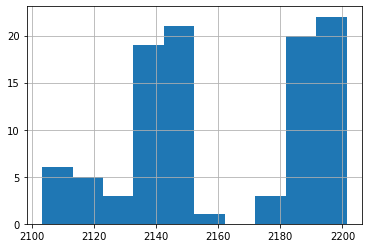

In [27]:
sample['admittime'].hist()

<AxesSubplot:>

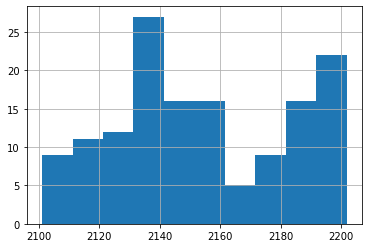

In [28]:
admissions_df['admittime'].hist()